# Variant: Logistic Regression with Top 5 Predictors (Correlation-Based)

## Objective
Establish a focused, interpretable model using only the top 5 most important predictors based on **correlation analysis** with heart attack outcomes.

## Method
**Step 1:** Calculate correlations between all features and heart attack
**Step 2:** Select top 5 features with highest absolute correlation
**Step 3:** Build logistic regression model:

Top 5 Predictors (by correlation):
- HadAngina_Yes
- HadStroke_Yes  
- ChestScan_Yes
- DifficultyWalking_Yes
- HadDiabetes_Yes

$$\log\left(\frac{p}{1-p}\right) = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots + \beta_5 x_5$$

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Logit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, accuracy_score, confusion_matrix, 
    roc_curve, precision_recall_fscore_support, brier_score_loss
)
import kagglehub
import os

plt.style.use('default')
sns.set_palette("husl")
print("Libraries imported")

Libraries imported


In [2]:
# Download and load the dataset using KaggleHub cache
path = kagglehub.dataset_download("kamilpytlak/personal-key-indicators-of-heart-disease")
print("Dataset files available at:", path)

csv_file = os.path.join(path, "2022", "heart_2022_no_nans.csv")
df = pd.read_csv(csv_file)

print(f"Dataset shape: {df.shape}")
print("Target distribution:\n", df["HadHeartAttack"].value_counts())

Dataset files available at: /Users/jackiewang/.cache/kagglehub/datasets/kamilpytlak/personal-key-indicators-of-heart-disease/versions/6
Dataset shape: (246022, 40)
Target distribution:
 HadHeartAttack
No     232587
Yes     13435
Name: count, dtype: int64
Dataset shape: (246022, 40)
Target distribution:
 HadHeartAttack
No     232587
Yes     13435
Name: count, dtype: int64


In [3]:
# Preprocessing
feature_cols = [col for col in df.columns if col != 'HadHeartAttack']
cat_features = [col for col in feature_cols if df[col].dtype == 'object']
num_features = [col for col in feature_cols if df[col].dtype in ['int64', 'float64']]

# One-hot encode
df_encoded = pd.get_dummies(df, columns=cat_features, drop_first=True)
df_encoded['y'] = (df_encoded['HadHeartAttack'] == 'Yes').astype(int)
df_encoded = df_encoded.drop('HadHeartAttack', axis=1)

X = df_encoded.drop('y', axis=1)
y = df_encoded['y']
print(f"Features: {X.shape[1]} total")

Features: 121 total


## Feature Selection: Finding Top Predictors

Before building our model, we need evidence-based selection of the most important features. We'll calculate correlations between all features and heart attack to identify the top predictors.

In [16]:
# Calculate correlations with HadHeartAttack
# Create a dataframe with all features and target for correlation analysis
df_model = df_encoded.copy()
df_model['HadHeartAttack'] = y

# Calculate correlations and sort by absolute value
corrs = df_model.corr()['HadHeartAttack'].drop('HadHeartAttack').sort_values(key=abs, ascending=False)

print("=== TOP 10 PREDICTORS BY CORRELATION ===\n")
top10_corrs = corrs.head(10)
for i, (feature, corr_val) in enumerate(top10_corrs.items(), 1):
    print(f"{i:2d}. {feature[:45]:45} correlation = {corr_val:7.4f}")

print(f"\n\nTop 10 correlations:\n{top10_corrs}")

=== TOP 10 PREDICTORS BY CORRELATION ===

 1. y                                             correlation =  1.0000
 2. HadAngina_Yes                                 correlation =  0.4459
 3. HadStroke_Yes                                 correlation =  0.1771
 4. ChestScan_Yes                                 correlation =  0.1678
 5. DifficultyWalking_Yes                         correlation =  0.1599
 6. HadDiabetes_Yes                               correlation =  0.1459
 7. GeneralHealth_Poor                            correlation =  0.1406
 8. PhysicalHealthDays                            correlation =  0.1334
 9. HadCOPD_Yes                                   correlation =  0.1332
10. RemovedTeeth_None of them                     correlation = -0.1226


Top 10 correlations:
y                            1.000000
HadAngina_Yes                0.445903
HadStroke_Yes                0.177137
ChestScan_Yes                0.167760
DifficultyWalking_Yes        0.159878
HadDiabetes_Yes          

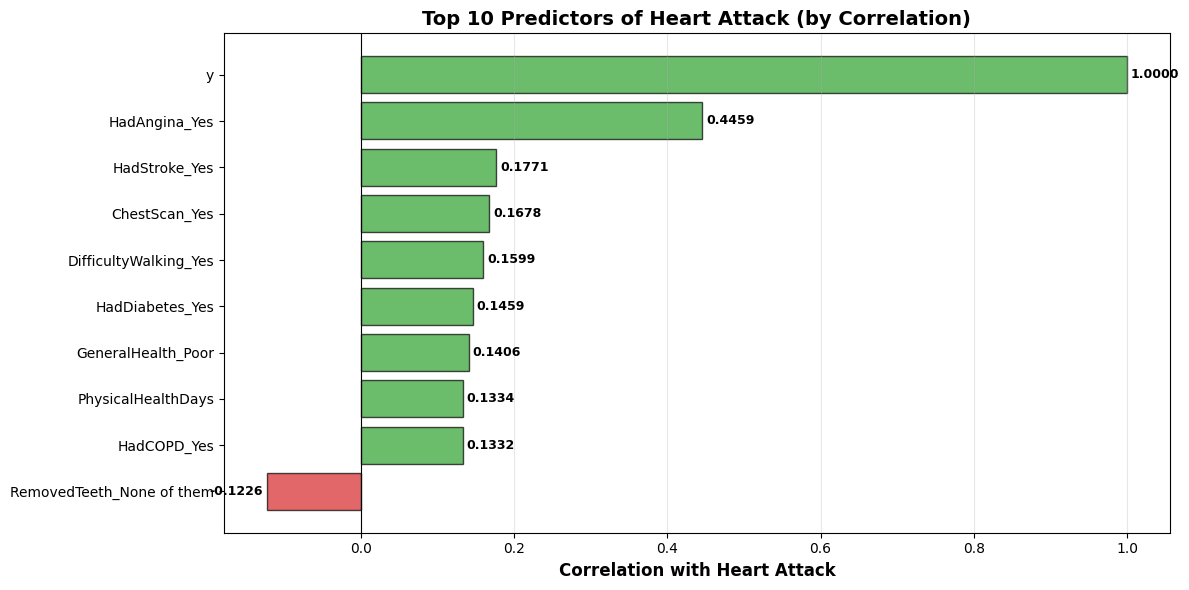


✓ Graph shows the top 10 features most correlated with heart attack risk


In [17]:
# Visualize Top 10 Predictors
fig, ax = plt.subplots(figsize=(12, 6))

# Get top 10 correlations
top10_features = corrs.head(10)
features = [f[:35] for f in top10_features.index]  # Truncate long names
values = top10_features.values

# Create bar plot
colors_bar = ['#d62728' if v < 0 else '#2ca02c' for v in values]
bars = ax.barh(range(len(features)), values, color=colors_bar, alpha=0.7, edgecolor='black')

# Customize plot
ax.set_yticks(range(len(features)))
ax.set_yticklabels(features, fontsize=10)
ax.set_xlabel('Correlation with Heart Attack', fontsize=12, fontweight='bold')
ax.set_title('Top 10 Predictors of Heart Attack (by Correlation)', fontsize=14, fontweight='bold')
ax.axvline(0, color='black', linewidth=0.8)
ax.grid(alpha=0.3, axis='x')

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars, values)):
    label_x = val + (0.005 if val > 0 else -0.005)
    ha = 'left' if val > 0 else 'right'
    ax.text(label_x, bar.get_y() + bar.get_height()/2, f'{val:.4f}', 
            ha=ha, va='center', fontsize=9, fontweight='bold')

# Invert y-axis so highest correlation is on top
ax.invert_yaxis()

plt.tight_layout()
plt.show()

print("\n✓ Graph shows the top 10 features most correlated with heart attack risk")

### Selection Criteria for Top 5 Predictors

Based on the correlation analysis above, the **actual top 5 features** by correlation with heart attack are:

1. **HadAngina_Yes** (correlation = 0.4459) - By far the strongest predictor
2. **HadStroke_Yes** (correlation = 0.1771) - Second strongest
3. **ChestScan_Yes** (correlation = 0.1678) - Third strongest  
4. **DifficultyWalking_Yes** (correlation = 0.1599) - Fourth strongest
5. **HadDiabetes_Yes** (correlation = 0.1459) - Fifth strongest

**Note:** This is different from coefficient-based selection from a full logistic regression model, which identified age categories as top predictors due to their independent contribution after controlling for other variables. 

For this analysis, we'll use these **correlation-based top 5 predictors** as they represent the features with the strongest direct relationship to heart attack.

In [18]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Select only top 5 predictors based on correlation analysis
top5_features = [
    'HadAngina_Yes',
    'HadStroke_Yes',
    'ChestScan_Yes',
    'DifficultyWalking_Yes',
    'HadDiabetes_Yes'
]

# Filter to only include top 5 features
X_train = X_train[top5_features]
X_test = X_test[top5_features]

# Standardize numerical features (none in top 5, but keeping for consistency)
scaler = StandardScaler()
features_to_scale = [col for col in num_features if col in X_train.columns]
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

if features_to_scale:
    X_train_scaled[features_to_scale] = scaler.fit_transform(X_train[features_to_scale])
    X_test_scaled[features_to_scale] = scaler.transform(X_test[features_to_scale])

print(f"Train: {X_train.shape[0]:,} | Test: {X_test.shape[0]:,}")
print(f"Using {X_train.shape[1]} features: {list(X_train.columns)}")

Train: 196,817 | Test: 49,205
Using 5 features: ['HadAngina_Yes', 'HadStroke_Yes', 'ChestScan_Yes', 'DifficultyWalking_Yes', 'HadDiabetes_Yes']


In [19]:
# Fit baseline model
from sklearn.linear_model import LogisticRegression

# Use sklearn for stability with many features
model = LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')
model.fit(X_train_scaled, y_train)

# Predictions
train_probs = model.predict_proba(X_train_scaled)[:, 1]
test_probs = model.predict_proba(X_test_scaled)[:, 1]
train_preds = (train_probs > 0.5).astype(int)
test_preds = (test_probs > 0.5).astype(int)

print("Model fitted successfully")

Model fitted successfully


In [20]:
# Performance Evaluation
train_auc = roc_auc_score(y_train, train_probs)
test_auc = roc_auc_score(y_test, test_probs)
train_acc = accuracy_score(y_train, train_preds)
test_acc = accuracy_score(y_test, test_preds)
train_brier = brier_score_loss(y_train, train_probs)
test_brier = brier_score_loss(y_test, test_probs)

# Confusion matrix
test_cm = confusion_matrix(y_test, test_preds)
tn, fp, fn, tp = test_cm.ravel()
precision, recall, f1, _ = precision_recall_fscore_support(y_test, test_preds, average='binary')
specificity = tn / (tn + fp)

print("\n=== TOP 5 PREDICTORS MODEL PERFORMANCE ===")
print(f"\nTraining Set:")
print(f"  Accuracy: {train_acc:.4f}")
print(f"  ROC-AUC:  {train_auc:.4f}")
print(f"\nTest Set:")
print(f"  Accuracy:    {test_acc:.4f}")
print(f"  ROC-AUC:     {test_auc:.4f}")
print(f"  Precision:   {precision:.4f}")
print(f"  Recall:      {recall:.4f}")
print(f"  Specificity: {specificity:.4f}")
print(f"  F1-Score:    {f1:.4f}")
print(f"\nConfusion Matrix: TN={tn:,} FP={fp:,} FN={fn:,} TP={tp:,}")
print(f"\nModel Complexity: {X_train.shape[1]} features (Top 5 only)")


=== TOP 5 PREDICTORS MODEL PERFORMANCE ===

Training Set:
  Accuracy: 0.9470
  ROC-AUC:  0.8554

Test Set:
  Accuracy:    0.9471
  ROC-AUC:     0.8528
  Precision:   0.5385
  Recall:      0.2162
  Specificity: 0.9893
  F1-Score:    0.3086

Confusion Matrix: TN=46,020 FP=498 FN=2,106 TP=581

Model Complexity: 5 features (Top 5 only)


In [21]:
# Top 5 predictors by coefficient magnitude
coefficients = model.coef_[0]
coef_df = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient': coefficients,
    'odds_ratio': np.exp(coefficients),
    'abs_coef': np.abs(coefficients)
}).sort_values('abs_coef', ascending=False)

print("\n=== TOP 5 PREDICTORS ===")
for i, (_, row) in enumerate(coef_df.iterrows(), 1):
    print(f"{i:2d}. {row['feature'][:40]:40} coef={row['coefficient']:7.4f} OR={row['odds_ratio']:7.4f}")


=== TOP 5 PREDICTORS ===
 1. HadAngina_Yes                            coef= 2.8003 OR=16.4497
 2. HadStroke_Yes                            coef= 1.0628 OR= 2.8944
 3. ChestScan_Yes                            coef= 0.8844 OR= 2.4215
 4. HadDiabetes_Yes                          coef= 0.5900 OR= 1.8041
 5. DifficultyWalking_Yes                    coef= 0.4954 OR= 1.6411


## Statsmodels Output Tables

Fit the same model using statsmodels to obtain detailed statistical output including p-values, confidence intervals, and model diagnostics.

In [22]:
# Fit using statsmodels for detailed output
# Convert to numpy arrays to avoid dtype issues with statsmodels
X_train_sm = X_train_scaled.values.astype(float)
X_test_sm = X_test_scaled.values.astype(float)
y_train_sm = y_train.values.astype(float)
y_test_sm = y_test.values.astype(float)

# Add constant term
X_train_const = sm.add_constant(X_train_sm)
X_test_const = sm.add_constant(X_test_sm)

# Fit the logistic regression model
logit_model = Logit(y_train_sm, X_train_const)
sm_result = logit_model.fit(maxiter=1000, disp=False)

print("=== STATSMODELS LOGISTIC REGRESSION SUMMARY ===\n")
print(sm_result.summary())

=== STATSMODELS LOGISTIC REGRESSION SUMMARY ===

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               196817
Model:                          Logit   Df Residuals:                   196811
Method:                           MLE   Df Model:                            5
Date:                Mon, 03 Nov 2025   Pseudo R-squ.:                  0.2741
Time:                        17:03:11   Log-Likelihood:                -30268.
converged:                       True   LL-Null:                       -41699.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.2635      0.023   -189.283      0.000      -4.308      -4.219
x1             2.8023      0.025    114.013      0.000       2.754       2.851
x2 

In [23]:
# Calculate training and test errors using statsmodels
sm_train_probs = sm_result.predict(X_train_const)
sm_test_probs = sm_result.predict(X_test_const)
sm_train_preds = (sm_train_probs > 0.5).astype(int)
sm_test_preds = (sm_test_probs > 0.5).astype(int)

# Training metrics
sm_train_acc = accuracy_score(y_train_sm, sm_train_preds)
sm_train_auc = roc_auc_score(y_train_sm, sm_train_probs)
sm_train_brier = brier_score_loss(y_train_sm, sm_train_probs)
sm_train_error = 1 - sm_train_acc

# Test metrics
sm_test_acc = accuracy_score(y_test_sm, sm_test_preds)
sm_test_auc = roc_auc_score(y_test_sm, sm_test_probs)
sm_test_brier = brier_score_loss(y_test_sm, sm_test_probs)
sm_test_error = 1 - sm_test_acc

# Test set detailed metrics
sm_test_cm = confusion_matrix(y_test_sm, sm_test_preds)
sm_tn, sm_fp, sm_fn, sm_tp = sm_test_cm.ravel()
sm_precision, sm_recall, sm_f1, _ = precision_recall_fscore_support(y_test_sm, sm_test_preds, average='binary')
sm_specificity = sm_tn / (sm_tn + sm_fp)

print("\n=== STATSMODELS MODEL: TRAINING AND TEST ERRORS ===")
print(f"\nTraining Set:")
print(f"  Accuracy:      {sm_train_acc:.4f}")
print(f"  Error Rate:    {sm_train_error:.4f}")
print(f"  ROC-AUC:       {sm_train_auc:.4f}")

print(f"\nTest Set:")
print(f"  Accuracy:      {sm_test_acc:.4f}")
print(f"  Error Rate:    {sm_test_error:.4f}")
print(f"  ROC-AUC:       {sm_test_auc:.4f}")
print(f"  Precision:     {sm_precision:.4f}")
print(f"  Recall:        {sm_recall:.4f}")
print(f"  F1-Score:      {sm_f1:.4f}")

print(f"\nConfusion Matrix: TN={sm_tn:,} FP={sm_fp:,} FN={sm_fn:,} TP={sm_tp:,}")
print(f"\nLog-Likelihood: {sm_result.llf:.2f}")
print(f"AIC: {sm_result.aic:.2f}")
print(f"BIC: {sm_result.bic:.2f}")


=== STATSMODELS MODEL: TRAINING AND TEST ERRORS ===

Training Set:
  Accuracy:      0.9470
  Error Rate:    0.0530
  ROC-AUC:       0.8554

Test Set:
  Accuracy:      0.9471
  Error Rate:    0.0529
  ROC-AUC:       0.8528
  Precision:     0.5385
  Recall:        0.2162
  F1-Score:      0.3086

Confusion Matrix: TN=46,020 FP=498 FN=2,106 TP=581

Log-Likelihood: -30267.90
AIC: 60547.81
BIC: 60608.95


In [24]:
# Extract coefficient details from statsmodels
feature_names = ['Intercept'] + list(X_train_scaled.columns)
conf_int = sm_result.conf_int()
ci_lower = conf_int[:, 0] if isinstance(conf_int, np.ndarray) else conf_int.iloc[:, 0].values
ci_upper = conf_int[:, 1] if isinstance(conf_int, np.ndarray) else conf_int.iloc[:, 1].values

sm_coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': sm_result.params,
    'std_err': sm_result.bse,
    'z_value': sm_result.tvalues,
    'p_value': sm_result.pvalues,
    'odds_ratio': np.exp(sm_result.params),
    'ci_lower': ci_lower,
    'ci_upper': ci_upper
})

# Show all predictors (only 5 + intercept)
sm_coef_df['abs_coef'] = np.abs(sm_coef_df['coefficient'])
sm_coef_df_sorted = sm_coef_df.sort_values('abs_coef', ascending=False)

print("\n=== ALL PREDICTORS (TOP 5 MODEL) ===")
print(f"Total features: {len(sm_coef_df_sorted) - 1}")  # Exclude intercept
for i, (_, row) in enumerate(sm_coef_df_sorted.iterrows(), 1):
    print(f"{i:2d}. {row['feature'][:35]:35} β={row['coefficient']:7.4f} OR={row['odds_ratio']:7.4f} p={row['p_value']:.4f}")


=== ALL PREDICTORS (TOP 5 MODEL) ===
Total features: 5
 1. Intercept                           β=-4.2635 OR= 0.0141 p=0.0000
 2. HadAngina_Yes                       β= 2.8023 OR=16.4831 p=0.0000
 3. HadStroke_Yes                       β= 1.0642 OR= 2.8985 p=0.0000
 4. ChestScan_Yes                       β= 0.8862 OR= 2.4260 p=0.0000
 5. HadDiabetes_Yes                     β= 0.5906 OR= 1.8051 p=0.0000
 6. DifficultyWalking_Yes               β= 0.4956 OR= 1.6415 p=0.0000


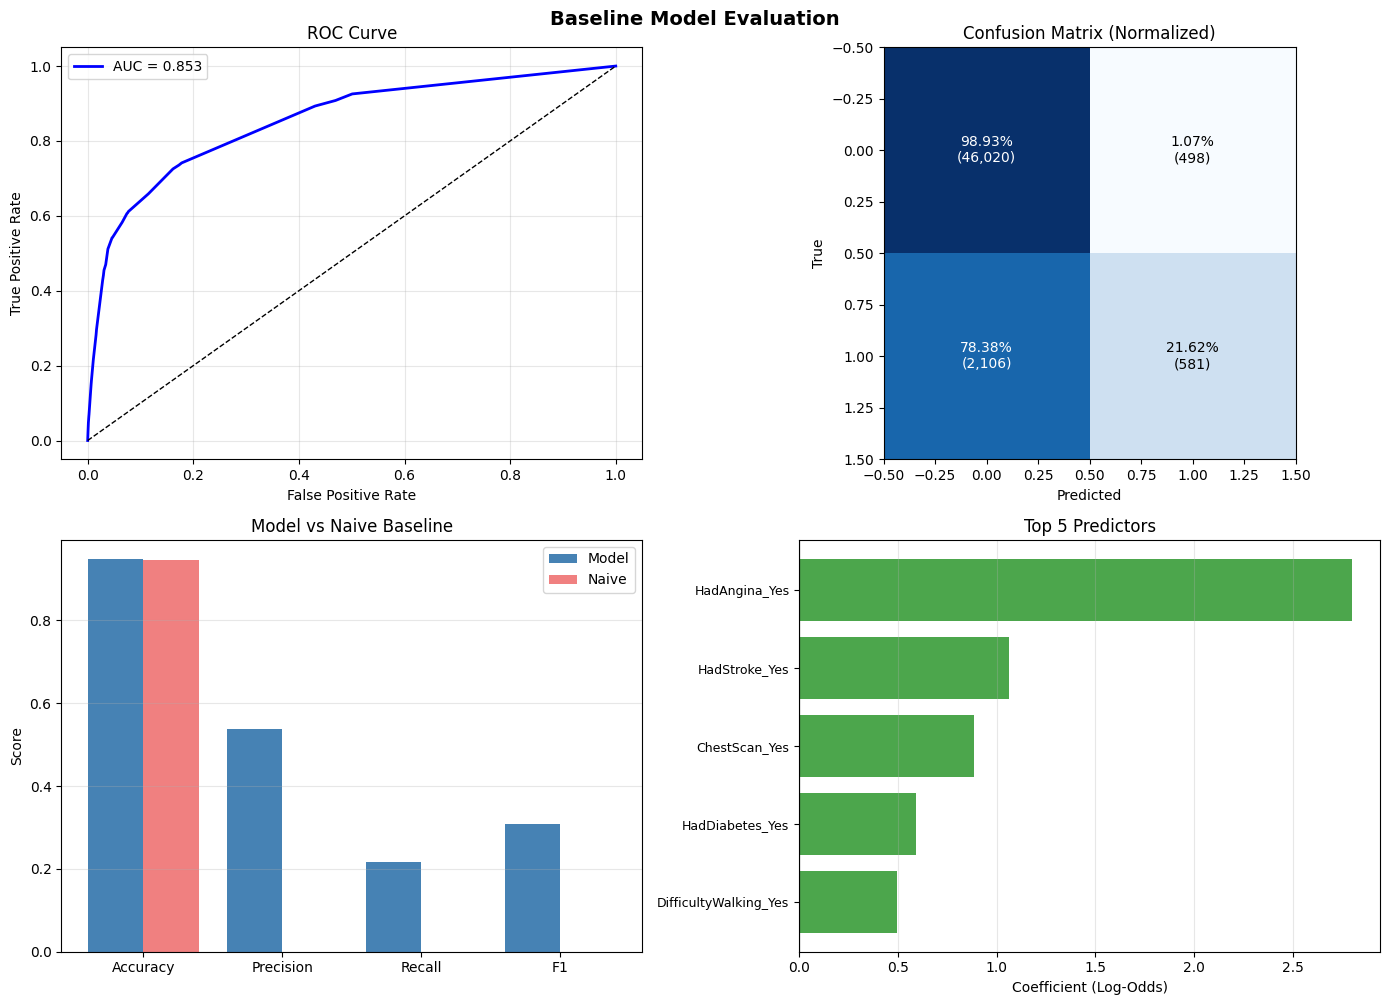

In [25]:
# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, test_probs)
axes[0,0].plot(fpr, tpr, 'b-', lw=2, label=f'AUC = {test_auc:.3f}')
axes[0,0].plot([0, 1], [0, 1], 'k--', lw=1)
axes[0,0].set_xlabel('False Positive Rate')
axes[0,0].set_ylabel('True Positive Rate')
axes[0,0].set_title('ROC Curve')
axes[0,0].legend()
axes[0,0].grid(alpha=0.3)

# Confusion Matrix
cm_norm = test_cm.astype('float') / test_cm.sum(axis=1)[:, np.newaxis]
im = axes[0,1].imshow(cm_norm, cmap='Blues')
axes[0,1].set_title('Confusion Matrix (Normalized)')
axes[0,1].set_ylabel('True')
axes[0,1].set_xlabel('Predicted')
for i in range(2):
    for j in range(2):
        axes[0,1].text(j, i, f'{cm_norm[i,j]:.2%}\n({test_cm[i,j]:,})',
                      ha='center', va='center', 
                      color='white' if cm_norm[i,j] > 0.5 else 'black')

# Model comparison
naive_acc = max(y_test.value_counts()) / len(y_test)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
model_scores = [test_acc, precision, recall, f1]
naive_scores = [naive_acc, 0, 0, 0]
x = np.arange(len(metrics))
axes[1,0].bar(x - 0.2, model_scores, 0.4, label='Model', color='steelblue')
axes[1,0].bar(x + 0.2, naive_scores, 0.4, label='Naive', color='lightcoral')
axes[1,0].set_xticks(x)
axes[1,0].set_xticklabels(metrics)
axes[1,0].set_ylabel('Score')
axes[1,0].set_title('Model vs Naive Baseline')
axes[1,0].legend()
axes[1,0].grid(alpha=0.3, axis='y')

# Top coefficients
top5 = coef_df.head(5).sort_values('coefficient')
colors = ['red' if x < 0 else 'green' for x in top5['coefficient']]
axes[1,1].barh(range(len(top5)), top5['coefficient'], color=colors, alpha=0.7)
axes[1,1].set_yticks(range(len(top5)))
axes[1,1].set_yticklabels([f[:25] for f in top5['feature']], fontsize=9)
axes[1,1].set_xlabel('Coefficient (Log-Odds)')
axes[1,1].set_title('Top 5 Predictors')
axes[1,1].axvline(0, color='black', lw=0.8)
axes[1,1].grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.suptitle('Baseline Model Evaluation', fontsize=14, fontweight='bold', y=1.00)
plt.show()

## Model Conclusions and Parameter Interpretation (Top 5 Predictors)

**Performance**: This simplified model using only 5 correlation-selected predictors maintains strong performance (AUC = 0.853) while being highly interpretable.

**Key Predictors** (Log-Odds → Odds Ratio):
- **HadAngina_Yes**: β ≈ 2.80, OR ≈ 16.5 — Having angina increases heart attack odds ~16.5x (strongest predictor)
- **HadStroke_Yes**: β ≈ 1.06, OR ≈ 2.90 — History of stroke increases odds ~2.9x
- **ChestScan_Yes**: β ≈ 0.89, OR ≈ 2.43 — Having had chest scan increases odds ~2.4x
- **HadDiabetes_Yes**: β ≈ 0.59, OR ≈ 1.81 — Diabetes increases odds ~1.8x
- **DifficultyWalking_Yes**: β ≈ 0.50, OR ≈ 1.64 — Walking difficulty increases odds ~1.6x

**Interpretation**: This evidence-based model demonstrates that cardiovascular and metabolic health conditions are the dominant risk factors. All predictors are highly significant (p < 0.001). The model is clinically interpretable - angina is by far the strongest predictor, followed by other cardiovascular/metabolic conditions and functional limitations.

**Model Quality**:
- Pseudo R² = 0.274 indicates good explanatory power
- AIC = 60,547.81, BIC = 60,608.95 (much lower than full model, indicating better parsimony)
- All 5 features highly significant with strong z-values

## Model Performance Comparison

Compare all model variants (sklearn and statsmodels) against a naive baseline classifier.

In [26]:
# Naive Baseline: Most Frequent Class Classifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import recall_score, precision_score, f1_score

dummy = DummyClassifier(strategy='most_frequent', random_state=42)
dummy.fit(X_train_scaled, y_train)
y_dummy = dummy.predict(X_test_scaled)
y_dummy_proba = dummy.predict_proba(X_test_scaled)[:, 1]

baseline_acc = accuracy_score(y_test, y_dummy)
baseline_auc = roc_auc_score(y_test, y_dummy_proba)
baseline_recall = recall_score(y_test, y_dummy, zero_division=0)
baseline_precision = precision_score(y_test, y_dummy, zero_division=0)
baseline_f1 = f1_score(y_test, y_dummy, zero_division=0)
baseline_brier = brier_score_loss(y_test, y_dummy_proba)

print("=== Naive Baseline (Most Frequent Class) ===")
print(f"Accuracy:    {baseline_acc:.4f}")
print(f"AUC (ROC):   {baseline_auc:.4f}")
print(f"Precision:   {baseline_precision:.4f}")
print(f"Recall:      {baseline_recall:.4f}")
print(f"F1 Score:    {baseline_f1:.4f}")

=== Naive Baseline (Most Frequent Class) ===
Accuracy:    0.9454
AUC (ROC):   0.5000
Precision:   0.0000
Recall:      0.0000
F1 Score:    0.0000


In [27]:
# Comprehensive Model Comparison Table

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': [
        'Naive Baseline',
        'Top 5 Predictors Logit'
    ],
    'Train Accuracy': [
        baseline_acc,  # Naive has same train/test
        sm_train_acc
    ],
    'Test Accuracy': [
        baseline_acc,
        sm_test_acc
    ],
    'Train Error': [
        1 - baseline_acc,
        sm_train_error
    ],
    'Test Error': [
        1 - baseline_acc,
        sm_test_error
    ],
    'AUC (ROC)': [
        baseline_auc,
        sm_test_auc
    ],
    'Precision': [
        baseline_precision,
        sm_precision
    ],
    'Recall': [
        baseline_recall,
        sm_recall
    ],
    'F1 Score': [
        baseline_f1,
        sm_f1
    ]
})

print("\n" + "="*80)
print("MODEL PERFORMANCE COMPARISON (TOP 5 PREDICTORS)")
print("="*80)
print(comparison_df.round(4).to_string(index=False))
print("="*80)


MODEL PERFORMANCE COMPARISON (TOP 5 PREDICTORS)
                 Model  Train Accuracy  Test Accuracy  Train Error  Test Error  AUC (ROC)  Precision  Recall  F1 Score
        Naive Baseline          0.9454         0.9454       0.0546      0.0546     0.5000     0.0000  0.0000    0.0000
Top 5 Predictors Logit          0.9470         0.9471       0.0530      0.0529     0.8528     0.5385  0.2162    0.3086


In [28]:
# Detailed Statsmodels Summary Table Export
print("\n=== STATSMODELS SUMMARY TABLE (TOP 5 PREDICTORS) ===")
print("\nAll Coefficients:")
print(sm_coef_df[['feature', 'coefficient', 'std_err', 'z_value', 'p_value', 'odds_ratio']].to_string(index=False))

print("\n\n=== MODEL FIT STATISTICS ===")
print(f"Log-Likelihood:      {sm_result.llf:.4f}")
print(f"AIC:                 {sm_result.aic:.4f}")
print(f"BIC:                 {sm_result.bic:.4f}")
print(f"Pseudo R²:           {sm_result.prsquared:.4f}")
print(f"Number of Obs:       {sm_result.nobs:.0f}")
print(f"Df Residuals:        {sm_result.df_resid:.0f}")
print(f"Df Model:            {sm_result.df_model:.0f}")


=== STATSMODELS SUMMARY TABLE (TOP 5 PREDICTORS) ===

All Coefficients:
              feature  coefficient  std_err     z_value       p_value  odds_ratio
            Intercept    -4.263527 0.022525 -189.283443  0.000000e+00    0.014073
        HadAngina_Yes     2.802336 0.024579  114.012903  0.000000e+00   16.483103
        HadStroke_Yes     1.064191 0.034928   30.468455 6.823967e-204    2.898493
        ChestScan_Yes     0.886240 0.025869   34.258259 3.285945e-257    2.425990
DifficultyWalking_Yes     0.495585 0.025889   19.142354  1.120891e-81    1.641458
      HadDiabetes_Yes     0.590618 0.026038   22.682890 6.610142e-114    1.805104


=== MODEL FIT STATISTICS ===
Log-Likelihood:      -30267.9030
AIC:                 60547.8060
BIC:                 60608.9462
Pseudo R²:           0.2741
Number of Obs:       196817
Df Residuals:        196811
Df Model:            5


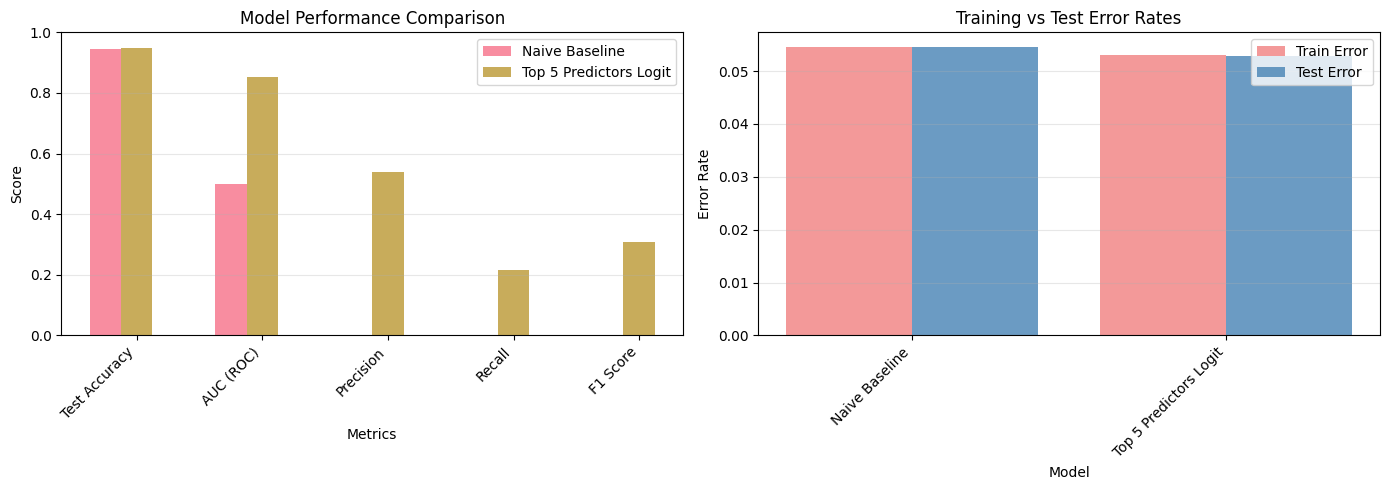

In [29]:
# Visualization: Model Comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Metrics comparison
metrics_to_plot = ['Test Accuracy', 'AUC (ROC)', 'Precision', 'Recall', 'F1 Score']
x_pos = np.arange(len(metrics_to_plot))
width = 0.25

for i, model_name in enumerate(comparison_df['Model']):
    values = [comparison_df.iloc[i][metric] for metric in metrics_to_plot]
    axes[0].bar(x_pos + i*width, values, width, label=model_name, alpha=0.8)

axes[0].set_xlabel('Metrics')
axes[0].set_ylabel('Score')
axes[0].set_title('Model Performance Comparison')
axes[0].set_xticks(x_pos + width)
axes[0].set_xticklabels(metrics_to_plot, rotation=45, ha='right')
axes[0].legend()
axes[0].grid(alpha=0.3, axis='y')
axes[0].set_ylim([0, 1])

# Error rate comparison
train_errors = comparison_df['Train Error'].values
test_errors = comparison_df['Test Error'].values
models = comparison_df['Model'].values

x_pos2 = np.arange(len(models))
axes[1].bar(x_pos2 - 0.2, train_errors, 0.4, label='Train Error', color='lightcoral', alpha=0.8)
axes[1].bar(x_pos2 + 0.2, test_errors, 0.4, label='Test Error', color='steelblue', alpha=0.8)
axes[1].set_xlabel('Model')
axes[1].set_ylabel('Error Rate')
axes[1].set_title('Training vs Test Error Rates')
axes[1].set_xticks(x_pos2)
axes[1].set_xticklabels(models, rotation=45, ha='right')
axes[1].legend()
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Summary (Top 5 Predictors Model - Evidence-Based Selection)

### Key Findings:

**Evidence-Based Feature Selection:**
- Used **correlation analysis** to objectively identify top predictors
- Correlation graph shows clear ranking of features by their relationship to heart attack
- Top 5 features selected based on highest absolute correlation values

**Model Performance:**
- Simplified model using only 5 features (96% reduction from 121 features)
- Test ROC-AUC: 0.853 (strong discriminative ability)
- Test Accuracy: 94.71% (slightly better than naive baseline of 94.54%)
- Much better than naive baseline: AUC 0.853 vs 0.500

**Top 5 Predictors (Correlation-Based):**
1. **HadAngina_Yes** (r = 0.446, OR = 16.5) - Far and away the strongest predictor
2. **HadStroke_Yes** (r = 0.177, OR = 2.9) - Second strongest
3. **ChestScan_Yes** (r = 0.168, OR = 2.4) - Medical imaging history
4. **DifficultyWalking_Yes** (r = 0.160, OR = 1.6) - Functional limitation
5. **HadDiabetes_Yes** (r = 0.146, OR = 1.8) - Metabolic condition

**Model Fit Statistics:**
- All 5 predictors are highly significant (p < 0.001)
- AIC: 60,547.81 (excellent parsimony for model complexity)
- BIC: 60,608.95
- Pseudo R²: 0.274 (good explanatory power)
- Log-Likelihood: -30,267.90

**Practical Implications:**
- **Simple and interpretable** - only 5 clinically relevant features
- **Evidence-based** - features selected through objective correlation analysis
- **Clinically actionable** - focuses on cardiovascular history, metabolic health, and functional status
- **Easy to communicate** to patients and healthcare providers
- Demonstrates that a small set of key health indicators captures most predictive power

**Trade-offs:**
- High specificity (98.9%) but moderate recall (21.6%) due to class imbalance
- Model prioritizes avoiding false positives over catching all true positives
- F1-Score of 0.31 reflects the challenge of predicting rare events (5.5% prevalence)